# Week 10: Semantics & Application

Additional references: 
- [Question Answering with huggingface](https://huggingface.co/transformers/usage.html)
- [Textual Entailment](https://nlp.stanford.edu/pubs/snli_paper.pdf)
- [SQuAD question answering](https://arxiv.org/abs/1606.05250)
- [SciFact Fact-checking](https://arxiv.org/abs/2004.14974)
- [Relatio](https://github.com/relatio-nlp/relatio)

In [ ]:
# upload sc_cases_cleaned.pkl to colab
from google.colab import files                                                                                                                                                                                       
uploaded = files.upload()

Saving sc_cases_cleaned.pkl to sc_cases_cleaned.pkl


In [ ]:
#setup
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

df = pd.read_pickle('sc_cases_cleaned.pkl', compression='gzip')
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 819
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   case_name       768 non-null    object        
 1   opinion_type    768 non-null    object        
 2   date_standard   768 non-null    datetime64[ns]
 3   authorship      768 non-null    object        
 4   x_republican    768 non-null    float64       
 5   maj_judges      768 non-null    object        
 6   dissent_judges  768 non-null    object        
 7   topic_id        768 non-null    float64       
 8   cite_count      768 non-null    float64       
 9   opinion_text    768 non-null    object        
 10  year            768 non-null    int64         
 11  log_cite_count  768 non-null    float64       
 12  author_id       768 non-null    int8          
dtypes: datetime64[ns](1), float64(4), int64(1), int8(1), object(6)
memory usage: 78.8+ KB


# Question Answering

There are different QA variants based on the inputs and outputs:

- Extractive QA: The model extracts the answer from a context. The context here could be a provided text, a table or even HTML! This is usually solved with BERT-like models.
- Open Generative QA: The model generates free text directly based on the context.
- Closed Generative QA: In this case, no context is provided. The answer is completely generated by a model.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00


#### Extractive QA

In [ ]:
from transformers import pipeline

# If no model checkpoint is given, the pipeline will be initialized with distilbert-base-cased-distilled-squad
nlp = pipeline("question-answering") 

context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the `run_squad.py`.
"""

print(nlp(question="What is extractive question answering?", context=context))
print(nlp(question="What is a good example of a question answering dataset?", context=context))

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.622244119644165, 'start': 34, 'end': 95, 'answer': 'the task of extracting an answer from a text given a question'}
{'score': 0.5115299224853516, 'start': 147, 'end': 160, 'answer': 'SQuAD dataset'}


#### Open Generative QA

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.6 MB/s eta 0:00:00


In [ ]:
from  transformers  import  AutoTokenizer, AutoModelWithLMHead, pipeline

model_name = "MaRiOrOsSi/t5-base-finetuned-question-answering"
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelWithLMHead.from_pretrained(model_name)
question = "Is Giacomo Italian?"
context = "Giacomo is 25 years old and he was born in Tuscany"
input = f"question: {question} context: {context}"
encoded_input = tokenizer([input],
                             return_tensors='pt',
                             max_length=512,
                             truncation=True)
output = model.generate(input_ids = encoded_input.input_ids,
                            attention_mask = encoded_input.attention_mask)
output = tokenizer.decode(output[0], skip_special_tokens=True)
print(output)

Yes, he was born in Tuscany.


#### Closed Generative QA

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# In closed QA, model need to rely on its parametric knowledge for QA.
t5_qa_model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-small-ssm-nq") # pre-trained on Wikipedia
t5_tok = AutoTokenizer.from_pretrained("t5-small")

input_ids = t5_tok("When was Franklin D. Roosevelt born?", return_tensors="pt").input_ids
gen_output = t5_qa_model.generate(input_ids)[0]

print(t5_tok.decode(gen_output, skip_special_tokens=True))

1917


# Textual Entailment

premise: Two women are wandering along the shore drinking iced tea.
hypothesis: Two women are sitting on a blanket near some rocks talking about politics.
label: (premise -> hypothesis, premise ? hypothesis, premise -x hypothesis)


In [ ]:
# using Transformers

from transformers import RobertaTokenizer, RobertaForSequenceClassification

model_name = "roberta-large-mnli" # mnli refers to the following dataset on which roberta was trained: https://cims.nyu.edu/~sbowman/multinli/
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
premise="Two women are wandering along the shore drinking iced tea."
hypothesis="Two women are sitting on a blanket near some rocks talking about politics."

model_input = tokenizer(premise, hypothesis, return_tensors="pt")
print (tokenizer.decode(model_input["input_ids"][0]))
# note how we obtain a single sequence with <s>premise</s></s>hypothesis</s>


<s>Two women are wandering along the shore drinking iced tea.</s></s>Two women are sitting on a blanket near some rocks talking about politics.</s>


In [ ]:
from torch.nn import Softmax
import torch

output = model(**model_input)
softmax = Softmax()
probs = softmax(output.logits)

In [ ]:
print (probs)

id2label = {0:"Contradiction", 1:"Neutral", 2:"Entailment"} # these are label2id from MNLI

argmax = torch.argmax(output.logits[0].detach()).item()
print (id2label[argmax])

#print (id2label[torch.argmax(output.logits)])

tensor([[0.8877, 0.1107, 0.0016]], grad_fn=<SoftmaxBackward0>)
Contradiction


In [ ]:
# do it for a whole batch

premises = ["If you help the needy, God will reward you.", "An interplanetary spacecraft is in orbit around a gas giant's icy moon.", "A large, gray elephant walked beside a herd of zebras.", "A handmade djembe was on display at the Smithsonian."]
hypotheses = ["Giving money to the poor has good consequences.", "The spacecraft has the ability to travel between planets.", "The elephant was lost.", "Visitors could see the djembe."] 

model_inputs = tokenizer(premises, hypotheses, return_tensors="pt", padding=True, truncation=True, max_length=256)


In [ ]:
output = model(**model_inputs)
softmax = Softmax()
probs = softmax(output.logits)

for premise, hypothesis, prediction in zip(premises, hypotheses, probs):
    argmax = torch.argmax(prediction).item()
    print (premise, "--", hypothesis, "--", id2label[argmax])

If you help the needy, God will reward you. -- Giving money to the poor has good consequences. -- Entailment
An interplanetary spacecraft is in orbit around a gas giant's icy moon. -- The spacecraft has the ability to travel between planets. -- Neutral
A large, gray elephant walked beside a herd of zebras. -- The elephant was lost. -- Neutral
A handmade djembe was on display at the Smithsonian. -- Visitors could see the djembe. -- Entailment


# Automated Fact-checking

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('Dzeniks/roberta-fact-check') # Trained on FEVER + HOVER
model = RobertaForSequenceClassification.from_pretrained('Dzeniks/roberta-fact-check')

# Define the claim with evidence to classify
claim = "Albert Einstein work in the field of computer science"
evidence = "Albert Einstein was a German-born theoretical physicist, widely acknowledged to be one of the greatest and most influential physicists of all time."

# Tokenize the claim with evidence
x = tokenizer.encode_plus(claim, evidence, return_tensors="pt")

model.eval()
with torch.no_grad():
  prediction = model(**x)

label = torch.argmax(prediction[0]).item()

print(f"Label: {label}")

Label: 0


However, wait... What is missing here?

What is the difference between textual entailment and Automated Fact-checking?

Is Fact-checking really a binary text classification task?

<b>In fact, fact-checking needs a pipeline instead of a single model.</b> The pipeline usually includes evidence retrieval and veracity prediction. Sometimes rationale selection is also required after evidence retrieval to select rationale sentences from the evidence essays which are very long.

#### Sci-Fact Dataset

In [ ]:
!wget https://scifact.s3-us-west-2.amazonaws.com/release/latest/data.tar.gz
!tar -xzf data.tar.gz

--2023-05-15 11:53:42--  https://scifact.s3-us-west-2.amazonaws.com/release/latest/data.tar.gz
Resolving scifact.s3-us-west-2.amazonaws.com (scifact.s3-us-west-2.amazonaws.com)... 52.218.178.129, 3.5.80.102, 52.92.213.122, ...
Connecting to scifact.s3-us-west-2.amazonaws.com (scifact.s3-us-west-2.amazonaws.com)|52.218.178.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3115079 (3.0M) [application/x-tar]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   2.97M  2.53MB/s    in 1.2s    

2023-05-15 11:53:44 (2.53 MB/s) - ‘data.tar.gz’ saved [3115079/3115079]



In [ ]:
!ls data

claims_dev.jsonl   claims_train.jsonl  cross_validation
claims_test.jsonl  corpus.jsonl


In [ ]:
import json

claim_file = 'data/claims_dev.jsonl'
corpus_file = 'data/corpus.jsonl'

corpus = {}
with open(corpus_file) as f:
    for line in f:
        abstract = json.loads(line)
        corpus[str(abstract["doc_id"])] = abstract
        
claims = []
with open(claim_file) as f:
    for line in f:
        claim = json.loads(line)
        claims.append(claim)

print(claims[1])
print(corpus['14717500'])

print("Number of Corpus: ", len(corpus))

{'id': 3, 'claim': '1,000 genomes project enables mapping of genetic sequence variation consisting of rare variants with larger penetrance effects than common variants.', 'evidence': {'14717500': [{'sentences': [2, 5], 'label': 'SUPPORT'}, {'sentences': [7], 'label': 'SUPPORT'}]}, 'cited_doc_ids': [14717500]}
{'doc_id': 14717500, 'title': 'Rare Variants Create Synthetic Genome-Wide Associations', 'abstract': ['Genome-wide association studies (GWAS) have now identified at least 2,000 common variants that appear associated with common diseases or related traits (http://www.genome.gov/gwastudies), hundreds of which have been convincingly replicated.', 'It is generally thought that the associated markers reflect the effect of a nearby common (minor allele frequency >0.05) causal site, which is associated with the marker, leading to extensive resequencing efforts to find causal sites.', 'We propose as an alternative explanation that variants much less common than the associated one may crea

In homework 10, we will conduct a more realistice fact-checking pipeline where <b>SBERT</b> (introduced in notebook 6) will be applied for evidence retrieval.

# Relatio
A tool for narrative statement extraction

In [ ]:
#!pip install relatio

In [ ]:
# Catch warnings for an easy ride
from relatio import FileLogger
logger = FileLogger(level = 'WARNING')

In [ ]:
from relatio import load_data
df = load_data(dataset = "trump_tweet_archive", content = "raw")

In [ ]:
from relatio import Preprocessor

p = Preprocessor(
    spacy_model = "en_core_web_sm",
    remove_punctuation = True,
    remove_digits = True,
    lowercase = True,
    lemmatize = True,
    remove_chars = ["\"",'-',"^",".","?","!",";","(",")",",",":","\'","+","&","|","/","{","}",
                    "~","_","`","[","]",">","<","=","*","%","$","@","#","’"],
    stop_words = [],
    n_process = -1,
    batch_size = 100
)

In [ ]:
df = p.split_into_sentences(
    df, output_path = None, progress_bar = True
)

Splitting into sentences...


100%|██████████| 32323/32323 [00:40<00:00, 797.07it/s]


In [ ]:
from relatio import SRL

SRL = SRL(
    path = "https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz",
    batch_size = 10,
    cuda_device = -1
)

srl_res = SRL(df['sentence'][0:1000], progress_bar=True)

from relatio import extract_roles

roles, sentence_index = extract_roles(
    srl_res, 
    used_roles = ["ARG0","B-V","B-ARGM-NEG","B-ARGM-MOD","ARG1","ARG2"],
    only_triplets = True,
    progress_bar = True
)

for d in roles[0:20]: print(d)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Output()

Running SRL...


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Extracting semantic roles...


100%|██████████| 1000/1000 [00:00<00:00, 26994.72it/s]

{'ARG0': 'Republicans and Democrats', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'thousands of hardworking American Patriots who', 'B-V': 'love', 'ARG1': 'our Country'}
{'ARG0': 'thousands of hardworking American Patriots who', 'B-V': 'cherish', 'ARG1': 'our values'}
{'ARG0': 'who', 'B-V': 'put', 'ARG1': 'AMERICA FIRST'}
{'ARG0': 'the Democrats', 'B-V': 'know', 'ARG1': 'it'}
{'ARG0': 'Almost all recent elections', 'B-V': 'using', 'ARG1': 'this system'}
{'ARG0': 'I', 'B-V': 'm', 'ARG1': 'running as a proud Democrat , for the Senate'}
{'ARG0': 'I', 'B-V': 'running', 'ARG1': 'for the Senate'}
{'ARG0': 'our County - China', 'B-V': 'own', 'B-ARGM-MOD': 'will', 'ARG1': 'us'}
{'ARG0': 'Sudan', 'B-V': 'agreed', 'ARG1': 'to a peace and normalization agreement with Israel'}
{'ARG0': 'that', 'B-V': 's', 'ARG1': 'to have done so in only a matter of weeks', 'ARG2': 'THREE Arabcountries'}
{'ARG0': 'Arabcountries', 'B-V': 'done', 'ARG1': 'so'}
{'ARG0': 'AdamLaxalt', 'B-V': 'finding',

In [ ]:
sentence_index, roles = p.extract_svos(df['sentence'], expand_nouns = True, only_triplets = False, progress_bar = True) 
for svo in roles[0:20]: print(svo)

Extracting SVOs...


100%|██████████| 63723/63723 [00:53<00:00, 1200.26it/s]


{'ARG0': 'Republicans', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'Democrats', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'B-V': 'hardworking', 'ARG1': 'American Patriots'}
{'ARG0': 'American Patriots', 'B-V': 'love', 'ARG1': 'our Country'}
{'B-V': 'cherish', 'ARG1': 'our values'}
{'B-V': 'respect', 'ARG1': 'our laws'}
{'B-V': 'put', 'ARG1': 'AMERICA FIRST'}
{'B-V': 'Thank', 'ARG1': 'you'}
{'ARG0': 'the Democrats', 'B-V': 'know', 'ARG1': 'it'}
{'B-V': 'using', 'ARG1': 'this system'}
{'ARG0': 'far fewer Ballots', 'B-V': 'count'}
{'ARG0': 'Almost all recent elections', 'B-V': 'ended'}
{'B-V': 'missing', 'ARG1': 'Ballots'}
{'B-V': 'missing', 'ARG1': 'amp'}
{'B-V': 'Getting', 'ARG1': 'a little exercise'}
{'B-V': 'Thank', 'ARG1': 'you'}
{'ARG0': 'The threshold identification', 'B-V': 'turning'}
{'B-V': 'anticipated'}
{'B-V': 'impacted', 'ARG1': 'A very large number'}
{'B-V': 'Stay'}


In [ ]:
!mkdir output
postproc_roles = p.process_roles(roles, 
                  max_length = 50,
                  progress_bar = True,
                  output_path = './output/postproc_roles.json')

Cleaning phrases for role ARG0...


100%|██████████| 50507/50507 [00:31<00:00, 1614.17it/s]


Cleaning phrases for role B-V...


100%|██████████| 93461/93461 [00:55<00:00, 1689.00it/s]


Cleaning phrases for role B-ARGM-MOD...


0it [00:00, ?it/s]


Cleaning phrases for role ARG1...


100%|██████████| 49369/49369 [00:30<00:00, 1612.00it/s]


Cleaning phrases for role ARG2...


0it [00:00, ?it/s]


In [ ]:
for d in postproc_roles[0:20]: 
  print(d)

{'ARG0': 'republican', 'B-V': 'create', 'ARG1': 'our economic problem'}
{'ARG0': 'democrats', 'B-V': 'create', 'ARG1': 'our economic problem'}
{'B-V': 'hardworke', 'ARG1': 'american patriot'}
{'ARG0': 'american patriot', 'B-V': 'love', 'ARG1': 'our country'}
{'B-V': 'cherish', 'ARG1': 'our value'}
{'B-V': 'respect', 'ARG1': 'our law'}
{'B-V': 'put', 'ARG1': 'america first'}
{'B-V': 'thank', 'ARG1': 'you'}
{'ARG0': 'the democrats', 'B-V': 'know', 'ARG1': 'it'}
{'B-V': 'use', 'ARG1': 'this system'}
{'ARG0': 'far few ballot', 'B-V': 'count'}
{'ARG0': 'almost all recent election', 'B-V': 'end'}
{'B-V': 'miss', 'ARG1': 'ballot'}
{'B-V': 'miss', 'ARG1': 'amp'}
{'B-V': 'get', 'ARG1': 'a little exercise'}
{'B-V': 'thank', 'ARG1': 'you'}
{'ARG0': 'the threshold identification', 'B-V': 'turn'}
{'B-V': 'anticipate'}
{'B-V': 'impact', 'ARG1': 'a very large number'}
{'B-V': 'stay'}


In [ ]:
from relatio.utils import load_roles
postproc_roles = load_roles('./output/postproc_roles.json')

In [ ]:
known_entities = p.mine_entities(
    df['sentence'], 
    clean_entities = True, 
    progress_bar = True,
    output_path = './output/entities.pkl'
)

for n in known_entities.most_common(10): print(n)

Mining named entities...


100%|██████████| 63723/63723 [00:47<00:00, 1350.81it/s]

('democrats', 1175)
('china', 920)
('obama', 897)
('u s', 820)
('trump', 695)
('american', 564)
('america', 557)
('barackobama', 530)
('republicans', 493)
('the united states', 448)


In [ ]:
from relatio.utils import load_entities
known_entities = load_entities('./output/entities.pkl')

top_known_entities = [e[0] for e in list(known_entities.most_common(100)) if e[0] != '']

In [ ]:
from relatio.narrative_models import NarrativeModel

m = NarrativeModel(
    clustering = 'kmeans',
    PCA = True,
    UMAP = True,
    roles_considered = ['ARG0', 'B-V', 'B-ARGM-NEG', 'ARG1'],
    roles_with_known_entities = ['ARG0','ARG1'],
    known_entities = top_known_entities,
    assignment_to_known_entities = 'embeddings',
    roles_with_unknown_entities = ['ARG0','ARG1'],
    threshold = 0.1
)    
             
m.fit(postproc_roles, progress_bar = True) 

Computing phrase embeddings...


100%|██████████| 10507/10507 [01:23<00:00, 125.15it/s]


Computing phrase embeddings...


100%|██████████| 16869/16869 [02:14<00:00, 125.38it/s]


Computing phrase embeddings...


100%|██████████| 24430/24430 [03:16<00:00, 124.34it/s]


Dimension reduction via PCA...
PCA parameters:
{'n_components': 50, 'svd_solver': 'full'}
Dimension reduction via UMAP...
UMAP parameters:
{'n_neighbors': 15, 'n_components': 2, 'random_state': 0}
Clustering phrases into clusters...
Clustering parameters chosen in this range:
{'n_clusters': [24, 60, 121, 182, 244], 'random_state': 0}
The silhouette score suggests the optimal number of clusters is 244. This corresponds to index 4.
The elbow method (inertia score) suggests the optimal number of clusters is 60. This corresponds to index 1.
Labeling the clusters by the most frequent phrases...


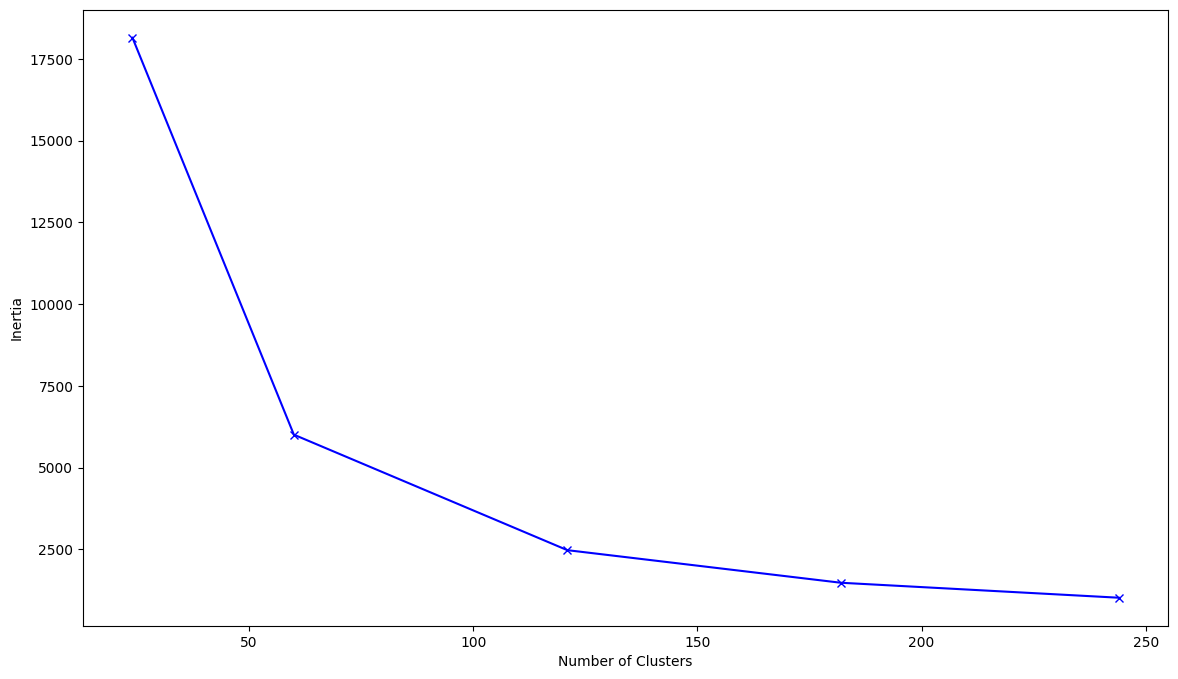

In [ ]:
m.plot_selection_metric(metric = 'inertia')

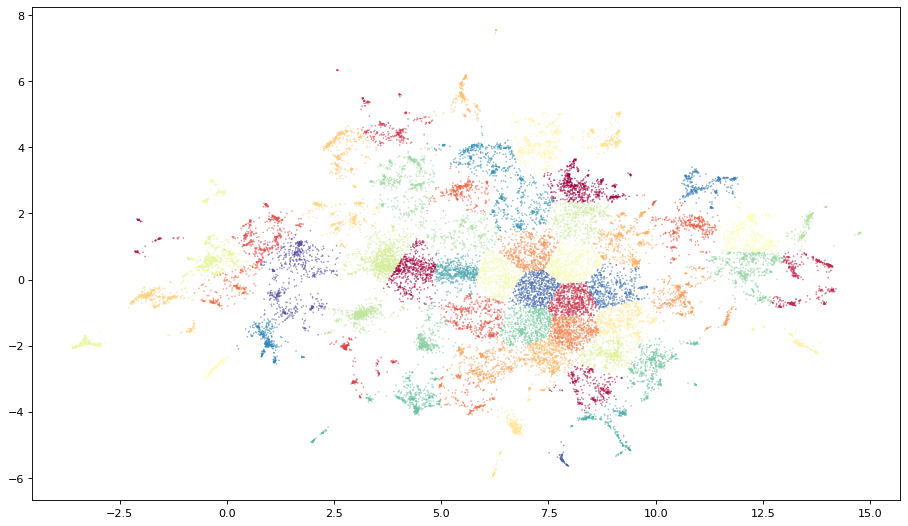

In [ ]:
m.plot_clusters(path = './output/clusters.pdf') 

In [ ]:
m.clusters_to_txt(path = './output/clusters.txt')

In [ ]:
narratives = m.predict(postproc_roles, progress_bar = True)


Predicting entities for role: ARG0...
Computing phrase embeddings...


100%|██████████| 50388/50388 [06:05<00:00, 137.85it/s]


Matching known entities (with embeddings distance)...
Matching unknown entities (with clustering model)...
Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...

Predicting entities for role: ARG1...
Computing phrase embeddings...


100%|██████████| 49026/49026 [06:06<00:00, 133.83it/s]


Matching known entities (with embeddings distance)...
Matching unknown entities (with clustering model)...
Dimension reduction of vectors (PCA)...
Dimension reduction of vectors (UMAP)...
Assignment to clusters...


In [ ]:
from relatio.utils import prettify

pretty_narratives = []
for n in narratives: 
    pretty_narratives.append(prettify(n))

for i in range(10):           
    print(roles[i])
    print(postproc_roles[i])
    print(pretty_narratives[i])

{'ARG0': 'Republicans', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'republican', 'B-V': 'create', 'ARG1': 'our economic problem'}
the democrats create money
{'ARG0': 'Democrats', 'B-V': 'created', 'ARG1': 'our economic problems'}
{'ARG0': 'democrats', 'B-V': 'create', 'ARG1': 'our economic problem'}
the democrats create money
{'B-V': 'hardworking', 'ARG1': 'American Patriots'}
{'B-V': 'hardworke', 'ARG1': 'american patriot'}
hardworke our country
{'ARG0': 'American Patriots', 'B-V': 'love', 'ARG1': 'our Country'}
{'ARG0': 'american patriot', 'B-V': 'love', 'ARG1': 'our country'}
our country love our country
{'B-V': 'cherish', 'ARG1': 'our values'}
{'B-V': 'cherish', 'ARG1': 'our value'}
cherish money
{'B-V': 'respect', 'ARG1': 'our laws'}
{'B-V': 'respect', 'ARG1': 'our law'}
respect crime
{'B-V': 'put', 'ARG1': 'AMERICA FIRST'}
{'B-V': 'put', 'ARG1': 'america first'}
put our country
{'B-V': 'Thank', 'ARG1': 'you'}
{'B-V': 'thank', 'ARG1': 'you'}
thank i
{'ARG0': 'the 